<a href="https://colab.research.google.com/github/antonysama/Projects_w._time_series/blob/master/land2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext rpy2.ipython

#connect to Drive

In [ ]:
import os
os.chdir('/content/drive/My Drive/TBF')
!pwd

/content/drive/My Drive/TBF


In [ ]:
#install packages & load
%%capture
%%R
install.packages(c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','readxl','forecast','lubridate','tsfeatures','zoo', dependencies = TRUE, repos="http://cloud.r-project.org"))
x<-c('dplyr', 'magrittr','skimr','tidyr','janitor','datetime','reshape2','readxl', 'forecast','lubridate','tsfeatures','zoo')
lapply(x, require, character.only = TRUE)

In [ ]:
%%R
#read the data, skim (& omit na's?)
df <- read_excel("land2.xlsx", sheet = "Sheet2") 
df$post2021 <- ifelse(df$Date >= "2021-01-01", "post21", "pre21")
skim_without_charts(df)
# df<-na.omit(df)

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             120   
Number of columns          15    
_______________________          
Column type frequency:           
  character                1     
  numeric                  13    
  POSIXct                  1     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 post2021              0             1   5   6     0        2          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable                   n_missing complete_rate       mean         sd
 1 ARPPricePerMcf_CAD                      0          1          3.17       1.21
 2 Prod_000GJ                             66          0.45  321138.     13884.  
 3 Oil_$/bbl                  

In [ ]:
%%R
#train test split
train <- df %>% filter (Date < "2022-07-01")
test <- df %>% filter (Date >= "2022-07-01")
dim(test)

[1] 66 15


In [ ]:
%%R
train %>% mutate_if(is.numeric, ~replace(., . == 0, NA)) #replace 0 with na
train$OS_PricePerHa = na.locf(train$OS_PricePerHa) #replace na with last observation
train$PNG_PS_DP_PricePerHectare_Total = na.locf(train$PNG_PS_DP_PricePerHectare_Total) #as above
skim_without_charts(train)

── Data Summary ────────────────────────
                           Values
Name                       train 
Number of rows             54    
Number of columns          15    
_______________________          
Column type frequency:           
  character                1     
  numeric                  13    
  POSIXct                  1     
________________________         
Group variables            None  

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 post2021              0             1   5   6     0        2          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable                   n_missing complete_rate       mean         sd
 1 ARPPricePerMcf_CAD                      0             1       2.25       1.06
 2 Prod_000GJ                              0             1  321138.     13884.  
 3 Oil_$/bbl                  

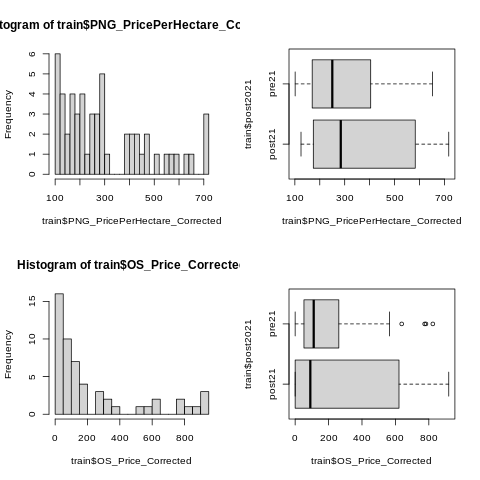

In [ ]:
%%R
 #correct outliers if plot shows
fun <- function(x){
  quantiles <- quantile( x, c(.05, .95 ) )
  x[ x < quantiles[1] ] <- quantiles[1]
  x[ x > quantiles[2] ] <- quantiles[2]
  x
}
train$PNG_PricePerHectare_Corrected <- fun(train$PNG_PS_DP_PricePerHectare_Total)
train$OS_Price_Corrected <- fun(train$OS_PricePerHa)
par(mfrow=c(2,2))
hist(train$PNG_PricePerHectare_Corrected, breaks = 30) 
boxplot(train$PNG_PricePerHectare_Corrected ~ train$post2021 , horizontal=TRUE)
hist(train$OS_Price_Corrected, breaks = 30) 
boxplot(train$OS_Price_Corrected ~ train$post2021 , horizontal=TRUE)

In [ ]:
%%R
#correlation plot
my_data<-train[,c("ARPPricePerMcf_CAD","Oil_$/bbl", "PerBbl_CAD", "ColdLakeBbl_CAD","PNG_PricePerHectare_Corrected")]
round(cor(my_data,use = "complete.obs"),2)
# corrplot(cor(my_data))

                              ARPPricePerMcf_CAD Oil_$/bbl PerBbl_CAD
ARPPricePerMcf_CAD                          1.00      0.40       0.49
Oil_$/bbl                                   0.40      1.00       0.95
PerBbl_CAD                                  0.49      0.95       1.00
ColdLakeBbl_CAD                             0.50      0.88       0.88
PNG_PricePerHectare_Corrected               0.33      0.02       0.14
                              ColdLakeBbl_CAD PNG_PricePerHectare_Corrected
ARPPricePerMcf_CAD                       0.50                          0.33
Oil_$/bbl                                0.88                          0.02
PerBbl_CAD                               0.88                          0.14
ColdLakeBbl_CAD                          1.00                          0.12
PNG_PricePerHectare_Corrected            0.12                          1.00


In [ ]:
%%R
#correlation plot
my_data2<-train[,c("ARPPricePerMcf_CAD","Oil_$/bbl", "PerBbl_CAD", "ColdLakeBbl_CAD","OS_Price_Corrected")]
round(cor(my_data2,use = "complete.obs"),2)

                   ARPPricePerMcf_CAD Oil_$/bbl PerBbl_CAD ColdLakeBbl_CAD
ARPPricePerMcf_CAD               1.00      0.40       0.49            0.50
Oil_$/bbl                        0.40      1.00       0.95            0.88
PerBbl_CAD                       0.49      0.95       1.00            0.88
ColdLakeBbl_CAD                  0.50      0.88       0.88            1.00
OS_Price_Corrected               0.17      0.13       0.20            0.14
                   OS_Price_Corrected
ARPPricePerMcf_CAD               0.17
Oil_$/bbl                        0.13
PerBbl_CAD                       0.20
ColdLakeBbl_CAD                  0.14
OS_Price_Corrected               1.00


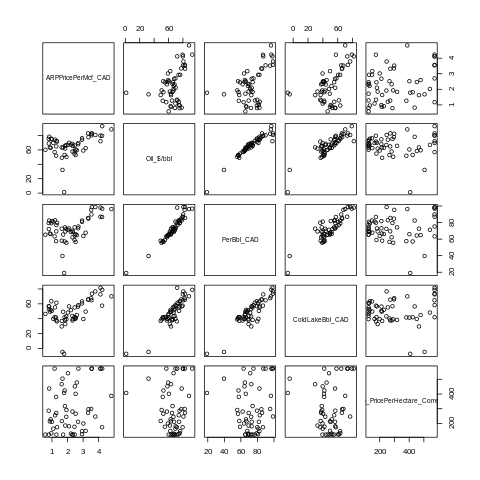

In [ ]:
%%R
plot(my_data)
# plot(df$ARPPricePerMcf_CAD , df$PNG_PS_DP_PricePerHectare_Total)


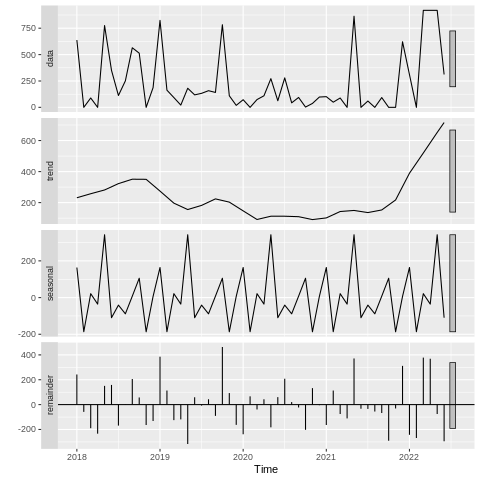

In [ ]:
%%R
# seasonality & trend
# mydata2=scan() # scan the above $/ha data from excel
# mydatats2 = ts(mydata2, start = c(2017,1,1), frequency = 12)
# mydatats2_corrected<- fun(mydatats2)
# autoplot(mydatats2)
# ggseasonplot(mydatats2)

tsdata2<-ts(train$OS_Price_Corrected, start = c(2018,1,1), frequency = 12)
# tsdata2<-ts(train$PNG_PricePerHectare_Corrected, start = c(2018,1,1), frequency = 12)
# autoplot(tsdata2)

# ggseasonplot(tsdata2)
# monthplot(tsdata2)

tldata2<-stl(tsdata2, t.window = 13, s.window="periodic")
autoplot(tldata2)

In [ ]:
%%R
#check for stationarity, if p>0.05 then stationary
# unitroot_kpss (train$PNG_PricePerHectare_Corrected)
unitroot_kpss (train$OS_Price_Corrected)

[1] 0.1917157


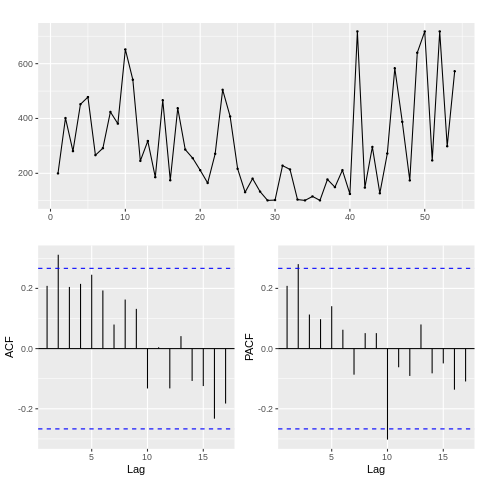

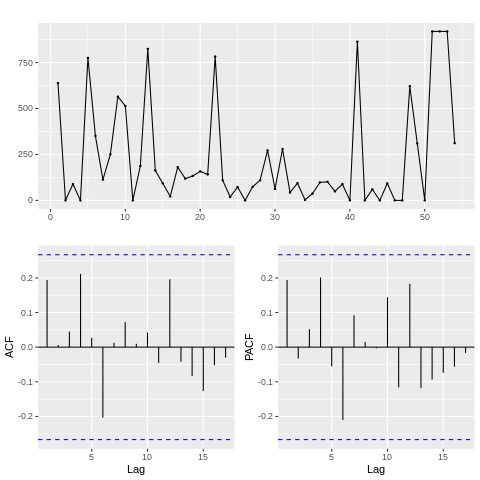

In [ ]:
%%R
# ggtsdisplay(df$PNG_PS_DP_PricePerHectare_Total)
ggtsdisplay(train$PNG_PricePerHectare_Corrected)
ggtsdisplay(train$OS_Price_Corrected)
# ggtsdisplay(diff(df$PNG_PS_DP_PricePerHectare_Total, differences=1))


In [ ]:
%%R
#lag
#  (fit4 <- auto.arima(train$PNG_PS_DP_PricePerHectare_Total, xreg = as.matrix(train[,c(2)])))
#  (fit4b <- auto.arima(test$PNG_PS_DP_PricePerHectare_Total, xreg = as.matrix(test[,c(2)])))
(fitpng <- auto.arima(train$PNG_PricePerHectare_Corrected, xreg = xts::lag.xts(as.matrix(train[,c(2)]))))
(fitos <- auto.arima(train$OS_Price_Corrected, xreg = xts::lag.xts(as.matrix(train[,c(2)]))))

Series: train$OS_Price_Corrected 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      ARPPricePerMcf_CAD
                 94.6493
s.e.             15.5244

sigma^2 = 77265:  log likelihood = -373.46
AIC=750.92   AICc=751.16   BIC=754.86


In [ ]:
%%R
#quadratic
# (fitpng2 <-auto.arima(train$PNG_PricePerHectare_Corrected, xreg = as.matrix(train[,c(2)]^2 ) ) ) 
# (fitos2 <- auto.arima(train$OS_Price_Corrected, xreg = as.matrix(train[,c(2)]^2 ) ) ) 

Series: train$PNG_PricePerHectare_Corrected 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept  ARPPricePerMcf_CAD
       236.0852             11.5231
s.e.    34.5239              4.2183

sigma^2 = 28868:  log likelihood = -352.91
AIC=711.81   AICc=712.29   BIC=717.78


In [ ]:
%%R
#forecast
fcpng <- forecast(fitpng,  h = 66, xreg = xts::lag.xts(as.matrix(test[,c(2)] ) ) )
fcos <- forecast(fitos, h = 66, xreg = xts::lag.xts(as.matrix(test[,c(2)] ) ) )
# fc5 <- forecast(fit5, h= 6, order=c(2,0,2))
# fc6 <- forecast(fit6, h= 6)
# fc7 <- forecast(fit7, h= 6)
# fc8 <- forecast(fit8, h=18, PI=T)

In [ ]:
%%R
df2 <-cbind(test,fcos$mean, fcpng$mean) 
df3<-df2[c("Date", "fcos$mean","fcpng$mean")]
write.csv(df3, "data.csv", row.names=FALSE)

In [ ]:
%%R
#check accuracy
accuracy(fc4c, test$PNG_PricePerHectare_Corrected) 

                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set  -1.255027 158.1156 124.4154 -28.47960 51.57303 0.8120004
Test set     170.928139 242.6441 209.7600  22.54867 35.55090 1.3690043
                   ACF1
Training set 0.04118492
Test set             NA


In [ ]:
%%R
round(test$PNG_PricePerHectare_Corrected)

[1] 718 299 572


In [ ]:
%%R
test[,c(1,11)]

# A tibble: 3 × 2
  Date                PNG_PS_DP_PricePerHectare_Total
  <dttm>                                        <dbl>
1 2022-04-01 00:00:00                            942.
2 2022-05-01 00:00:00                            299.
3 2022-06-01 00:00:00                            572.
